<a href="https://colab.research.google.com/github/hrhampapura/ams_ai_shortcourse_2025/blob/main/AMSAI2025_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AMS AI Short Course: Model Evaluation

**AMS AI Short Course**

This Colab Notebook demonstrates model evaluation methods for regression models. The Notebook uses a pretrained model: a simple multi-layer perceptron (MLP) that uses a sequence of hourly air and water temperatures to predict water temperature with a a 12-hour lead time.

**Machine Learning Model: Laguna Madre Water Temperature Prediction**
- Features: sequence of 6 hourly temperature values (wind and water: 12 features)
- Prediction: water temperature (12 hour lead time)
- Model architecture: Multilayer perceptron
- [Dataset provided by White et al. (2024)](https://www.sciencedirect.com/science/article/pii/S2352340923008909)
- [Link to pretrained model (.keras file)](https://github.com/ekrell/ams_ai_shortcourse_2025/raw/refs/heads/main/data/laguna_madre_watertemp.keras)

**Model Task: Predict Cold Stunning Events**

When water temperature stays at 8.0°C or below for 24 hours or more, a significant number of sea turtles in the Laguna Madre, potentially thousands, become cold stunned ([Shaver et al., 2017](https://doi.org/10.1371/journal.pone.0173920)).

There is a need for early warning that the water temperatures are likely to pass this temperature threshold.

**The model used in this notebook is a very simple MLP used to illustrate model evaluation concepts is substally less skillful that the [Coastal Dynamic Lab's operational model](https://cbigrid.tamucc.edu/tpw/).**

# Setup

**Set options**

In [1]:
# Which years to include in the dataset
selected_years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

# Model lead time
lead_time_hours = 12

# Number of previous hours included in predictors
prev_pred_hours = 6

# Pretrained model file (must match the lead time, predictor hours above)
trained_model_url = "https://github.com/ekrell/ams_ai_shortcourse_2025/raw/refs/heads/main/data/laguna_madre_watertemp.keras"

**Libraries**

In [2]:
from google.colab.output import eval_js
import numpy as np
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import keras
import tensorflow as tf
from keras.models import load_model

**Load dataset**

In [3]:
selected_years = np.array(selected_years)

remote_directory = "https://raw.githubusercontent.com/conrad-blucher-institute/LagunaMadreWaterAirTempDataCleaner/main/imputed_data"
file_format = "atp_and_wtp_{}.csv"

data_files_remote = [
    remote_directory + "/" + file_format.format(str(year)) \
     for year in selected_years
]

data_files = ["temperature_{}.csv".format(str(year)) for year in selected_years]

for i in range(len(data_files)):
  urllib.request.urlretrieve(data_files_remote[i], data_files[i])

!ls

sample_data	      temperature_2015.csv  temperature_2018.csv  temperature_2021.csv
temperature_2013.csv  temperature_2016.csv  temperature_2019.csv  temperature_2022.csv
temperature_2014.csv  temperature_2017.csv  temperature_2020.csv


In [7]:
#cat temperature_2015.csv

In [4]:
# Load all downloaded file into a Pandas data frame
df = pd.concat(map(pd.read_csv, data_files))

# Easier to read column names
df.rename(columns={'dateAndTime'           : 'datetime',
                   'packeryATP_lighthouse' : 'atp',
                   'npsbiWTP_lighthouse'   : 'wtp'}, inplace=True)

# Tell Pandas the "datetime" column, so that we can use Pandas time series functionality
df['datetime'] = pd.to_datetime(df["datetime"])
df = df.set_index('datetime')

df

,atp,wtp
datetime,,
2013-01-01 00:00:00,20.6,14.5
2013-01-01 01:00:00,20.7,14.6
2013-01-01 02:00:00,19.2,14.4
2013-01-01 03:00:00,20.5,14.2
2013-01-01 04:00:00,20.0,14.6
...,...,...
2022-12-31 19:00:00,19.8,16.5
2022-12-31 20:00:00,22.3,16.8
2022-12-31 21:00:00,21.4,17.4


## Preprocess dataset

The dataset comes in the form of an ordered table of time series values.

But, we need it to be in the form of predictors and targets.

- Targets: single water temperature values in Celsius
- Inputs: a sequence of water temperature values and air temperature values where the most recent is L (lead time) hours before the target. The sequence goes back (N) previous hours.

The following function `split_preds_targets` converts the input dataframe into a set of inputs (`x`) and targets (`y`).

**Preprocessing pipeline:**

1. Replace missing values with mean
2. Normalize predictors
3. Convert to x, y dataset


In [ ]:
def split_preds_targets(df, lead_time_hours, target_var="wtp", prev_pred_hours=3):

  data = df.to_numpy()
  n_samples = len(data)

  # Adjust lead time hours to start from end of predictor time series
  lead_time_hours = lead_time_hours + prev_pred_hours

  start_idxs = np.array(range(0, n_samples - prev_pred_hours)).astype(int)
  stop_idxs = start_idxs + prev_pred_hours
  n_train = len(start_idxs)

  x = np.zeros((n_train, data.shape[1] * prev_pred_hours))
  for i in range(n_train):
    x[i] = data[start_idxs[i]:stop_idxs[i]].flatten()
  x = x[:-lead_time_hours]

  y = df[target_var][lead_time_hours:].to_numpy()
  y = y[:-prev_pred_hours]

  feature_names = []
  for i in range(prev_pred_hours):
    for colname in df.columns:
      feature_names.append(colname + "-" + str(prev_pred_hours - i - 1))

  return x, y, feature_names

# Impute missing values with mean
dfi = df.interpolate(method='linear')
dfi.index.freq = 'h'

# Normalization
df_all = dfi[dfi.index.year.isin(selected_years)]
# Convert to numpy preds & targets
x, y, feature_names = split_preds_targets(df_all, lead_time_hours, prev_pred_hours=prev_pred_hours)

# Build normalization layer
normalizer = keras.layers.Normalization(axis=-1)
normalizer.adapt(x)

**Load pretrained regression model**

In [ ]:
trained_model_path = "model_regression.keras"
urllib.request.urlretrieve(trained_model_url, trained_model_path)
model = load_model(trained_model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Initial performance evaluation

We will analyze the performance of the model by calculating conventional performance metrics across the entire set of samples

- R-squared (R2)
  - Common metric for evaluating regression
  - Best R2 is 1.0
  - Sometimes you'll hear it defined between [0.0, 1.0]
  - But negative R2 is not uncommon in ML: [why?](http://www.fairlynerdy.com/what-is-r-squared/)
- Mean absolute error (MAE)
  - Simple but meaningful metric: mean difference between prediction and target
  - Use absolute values we are considering error magnitude and don't want positive and negatives errors to cancel each other
  - Same units as target
- Mean squared error (MSE)
  - Penalizes larger errors more
  - Commonly used as the loss function to train the model

In [ ]:
# Make predictions for all sample
preds = model.predict(x).flatten()

2739/2739 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step


**Error value interpretation**

Here, we calculate errors with:

    prediction - target

- Positive errors: "hot errors" where model overpredicts temperature
- Negative errors: "cold errors" where model underpredicts temperature

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

# Mean error: NOT a conventional metric since errors can be pos and neg
ME = np.mean(preds - y)
R2 = r2_score(y, preds)
MAE = mean_absolute_error(y, preds)
MSE = mean_squared_error(y, preds)
RMSE = root_mean_squared_error(y, preds)

print("R2: {:.3f}".format(R2))
print("ME: {:.3f} °C".format(ME))
print("MAE: {:.3f} °C".format(MAE))
print("MSE: {:.3f} °C^2".format(MSE))
print("RMSE: {:.3f} °C".format(RMSE))

R2: 0.962
ME: -0.221 °C
MAE: 0.947 °C
MSE: 1.531 °C^2
RMSE: 1.237 °C


**Initial intepretation:**

The model does a good job of tracking the overall trend. The high R2 suggests that the model predicts lower temps when there will be lower temps, and *vice versa*. But, the MAE of ~1.0 indicates that the predictions are off, on average, by a degree Celsius. This could be a problem for stake-holders relying on the model for taking action in a cold-stunning event.

The above is a **very** simplistic approach to model evaluation. Such a **global view** of model performance may hide interesting details.

# Error time series overview

**Setup (targets, predictions, error) data frame**

In [ ]:
# Calculate error
y_error = preds - y

# Create dataframe of target, prediction, error
dfy = pd.DataFrame(list(zip(y, preds, y_error)), columns=["target", "prediction", "error"])
# Add time index
dfy['datetime'] = df.index[lead_time_hours:-prev_pred_hours*2]
dfy = dfy.set_index('datetime')

In [ ]:
# Plot colors
tcolor = "tab:blue"
pcolor = "tab:orange"
ecolor = "tab:purple"

def plot_pred_timeseries(dfy, start=None, stop=None):

  # dfy: pandas DataFrame with columns "target", "prediction", "error"
  # start: datetime to define start of plot time range   (format: "mm/dd/yyyy")
  # stop: datetime to define end of plot time range      (format: "mm/dd/yyyy")

  if start is None:
    start = dfy.index[0]
  if stop is None:
    stop = dfy.index[-1]

  # dfy: Pandas DataFrame with columns 'target', 'prediction', 'error'
  dfy = dfy.loc[start:stop]

  # dfy: Pandas DataFrame with columns 'target', 'prediction', 'error'
  fig, ax = plt.subplots(3, figsize=(18, 10))

  # Targets on preds
  ax[0].plot(dfy["prediction"], label="prediction", c=pcolor)
  ax[0].plot(dfy["target"], label="target", c=tcolor)
  ax[0].legend()
  ax[0].set_ylabel("Celsius")

  # Preds on targets
  ax[1].plot(dfy["target"], label="target", c=tcolor)
  ax[1].plot(dfy["prediction"], label="prediction", c=pcolor)
  ax[1].legend()
  ax[1].set_ylabel("Celsius")

  # Errors
  ax[2].plot(dfy["error"], label="error", c=ecolor)
  ax[2].legend()
  ax[2].set_ylabel("Celsius")


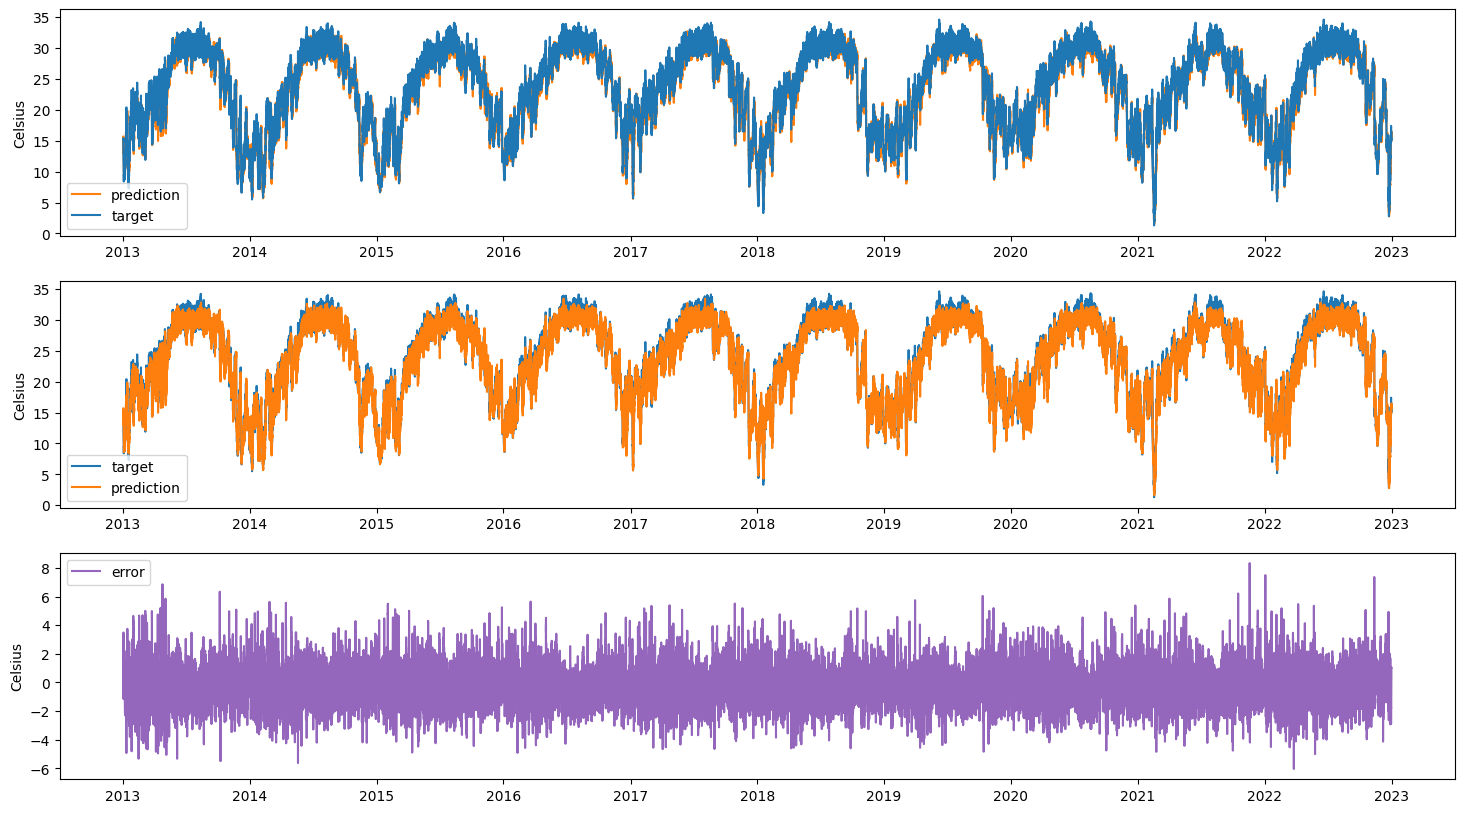

In [ ]:
plot_pred_timeseries(dfy)

**Zoom in on region of interest**

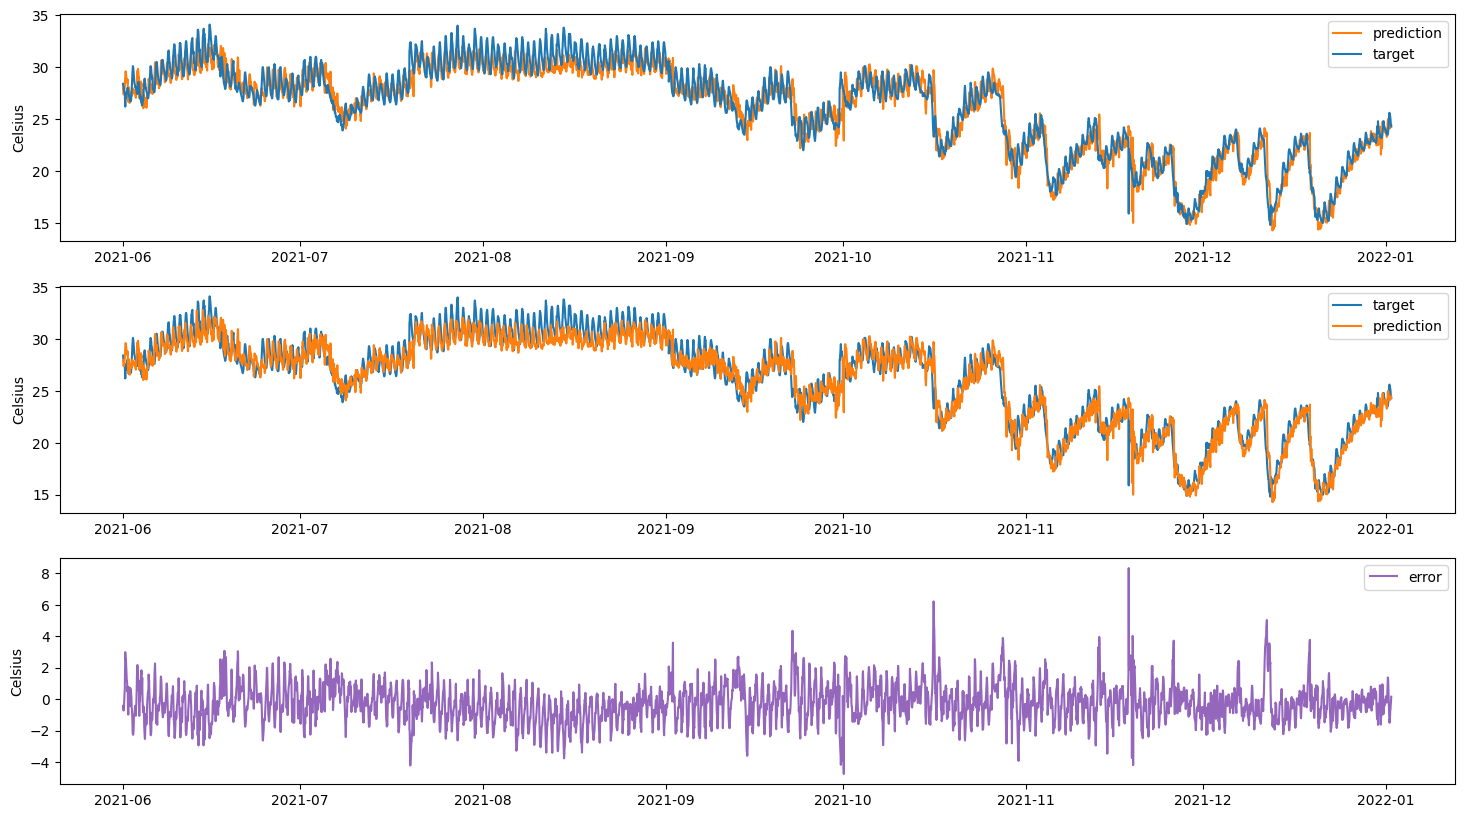

In [ ]:
plot_pred_timeseries(dfy, start="06/01/2021", stop="01/01/2022")

With this zoom-in, we can see some larger errors that are not assiociated with the cold-stunning season (winter). In general, the model has a tendency to under-predict the temperature.

**Caution:** while it is a good idea to analyze extreme events, be careful to not over-tweak the model for one extreme case.

# Error distribution analysis

A single summary metric (e.g. MAE) does not tell you about the actual errors that may be encountered.

- Are there errors skewed in some way?
- Bimodal?
- What kind of errors should I expect to see in practice?
- How bad do the errors get and how rare are they?

(-0.365, 37.994743996858595)

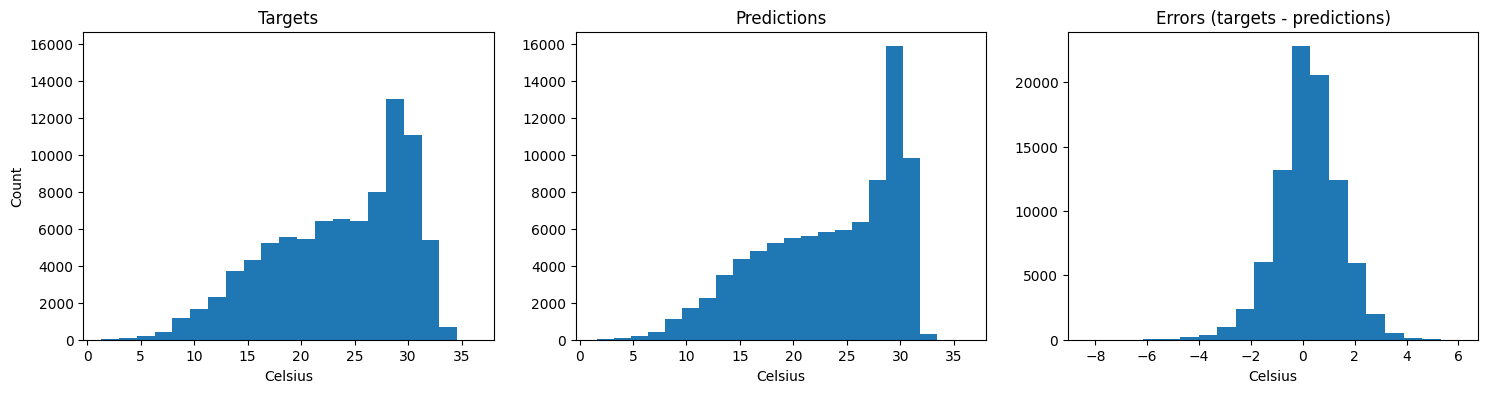

In [ ]:
y_error = y - preds

fig, axs = plt.subplots(1, 3, figsize=(18, 4))

axs[0].hist(y, bins=20)
axs[0].set_ylabel("Count")
axs[0].set_title("Targets")
axs[0].set_xlabel("Celsius")

axs[1].hist(preds, bins=20)
axs[1].set_title("Predictions")
axs[1].set_xlabel("Celsius")

axs[2].hist(y_error, bins=20);
axs[2].set_xlabel("Celsius")
axs[2].set_title("Errors (targets - predictions)")

ymin = min(axs[0].get_ylim()[0], axs[1].get_ylim()[0])
ymax = max(axs[0].get_ylim()[1], axs[1].get_ylim()[1])
axs[0].set_ylim([ymin, ymax])
axs[1].set_ylim([ymin, ymax])

xmin = min(axs[0].get_xlim()[0], axs[1].get_xlim()[1])
xmax = max(axs[0].get_xlim()[0], axs[1].get_xlim()[1])
axs[0].set_xlim([xmin, xmax + 3])
axs[1].set_xlim([xmin, xmax + 3])

In [ ]:
print("Mean error: {:.3f} °C".format(np.mean(y_error)))
print("Median error: {:.3f} °C".format(np.median(y_error)))
print("")

print("Min error: {:.3f} °C".format(np.min(y_error)))
print("Mean absolute error: {:.3f} °C".format(np.mean(np.abs(y_error))))
print("Max error: {:.3f} °C".format(np.max(y_error)))

Mean error: 0.221 °C
Median error: 0.231 °C

Min error: -8.334 °C
Mean absolute error: 0.947 °C
Max error: 6.047 °C


The distribution of temperature values is not smooth, and has a negative skew. This show us that the **range of warm water temperatures is much smaller than the range of colder temperatures**.

Perhaps the model more easily learns the relatively smoother *below mean* distribution compared to the steeper *above mean* distribution? Model seems hesitant to predict temperatures toward 35°C. The model has a tendancy toward predicting the mean value.

**Modeling note:** we assume that we are capturing the heat input to the system through the air temperature. This is pretty good because the Laguna Madre is fairly cutoff thermally from the Gulf of Mexico, Corpus Christi Bay to the North and the Brownsville ship channel to the North plus no rivers. But we don’t have a good input for direct radiative transfer (ongoing measurements) which may be a source of error during the warm ups after cold front.

# Temporal error variation

In many applications, model performance can vary in time.

- For example, a model might perform better in warmer months.
- Or, there may be a specific year that exhibited an unusual event (e.g. major storm or long-term climatic event).

**Moving aggregates:** By rolling over the time series, operations (e.g. mean, sum) can be applied to temporal groups (e.g. monthly means). This is a type of convolution.

**Group aggregates:** Or, those operations can be applied to *all* group members. That is, the mean of _May_ will include all years in the time series.

The difference between the two is that a **moving** aggregate will provide a separate monthly mean for each year, while a **group** aggregate will provide a mean for all values in the month, across all years.

**Moving aggregates**

Text(0.5, 1.0, 'Quarterly')

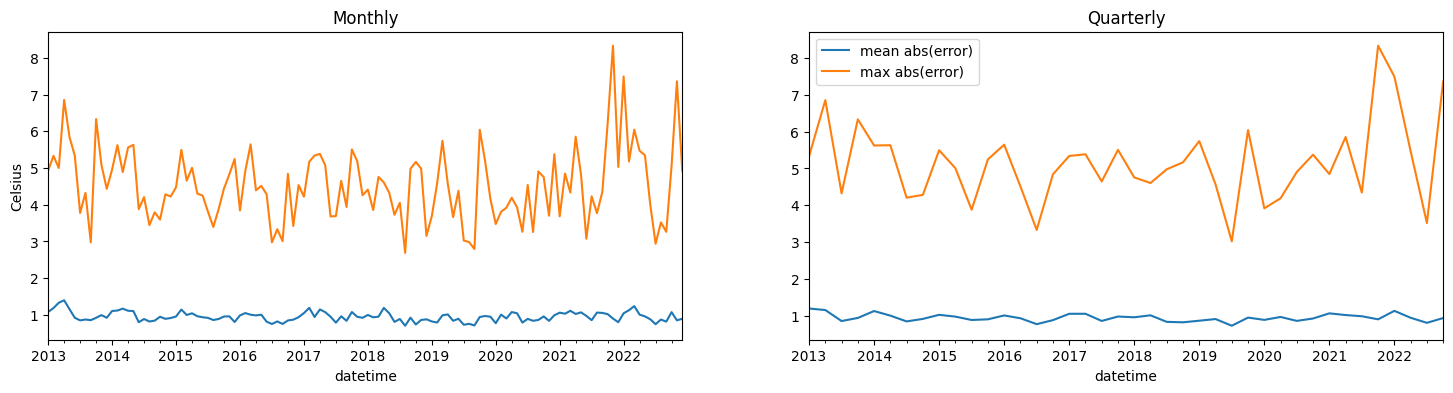

In [ ]:
dfy["abs_error"] = np.abs(dfy["error"])

fig, axs = plt.subplots(1, 2, figsize=(18, 4))

dfy["abs_error"].resample('MS').mean().plot(ax=axs[0], label="mean abs(error)")
dfy["abs_error"].resample('QS').mean().plot(ax=axs[1], label="mean abs(error)")

dfy["abs_error"].resample('MS').max().plot(ax=axs[0], label="max abs(error)")
dfy["abs_error"].resample('QS').max().plot(ax=axs[1], label="max abs(error)")

plt.legend()

axs[0].set_title("Monthly")
axs[0].set_ylabel("Celsius")
axs[1].set_title("Quarterly")

**Group aggregates**

Text(0, 0.5, 'Celsius')

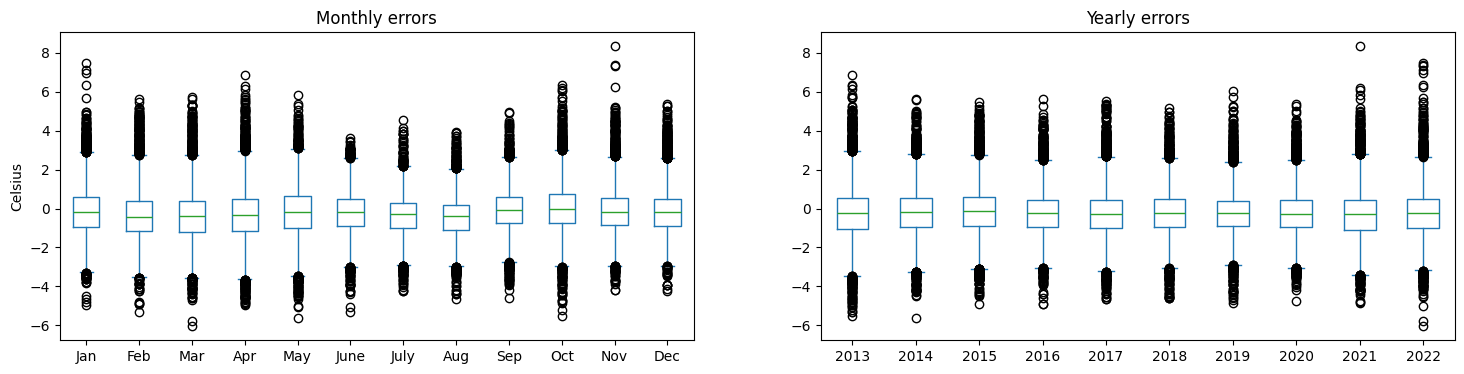

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18, 4))

dfy.set_index(dfy.index.month, append=True)['error'].unstack().plot.box(ax=axs[0])
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]
axs[0].set_xticklabels(month_labels);
axs[0].set_title("Monthly errors")

dfy.set_index(dfy.index.year, append=True)['error'].unstack().plot.box(ax=axs[1])
axs[1].set_title("Yearly errors")

axs[0].set_ylabel("Celsius")

**Monthly and Yearly Peformance breakdown**

While we are at it, we can think about **model generalization**: performance on data not seen during the training process.

In the case, year 2022 was held out as an independent test set.

In [ ]:
months = np.array(range(1, 13))
scores = np.zeros((len(months), 4))

for m in months:
  dfm = dfy[dfy.index.month == m]
  R2 = r2_score(dfm["target"], dfm["prediction"])
  MAE = mean_absolute_error(dfm["target"], dfm["prediction"])
  MSE = mean_squared_error(dfm["target"], dfm["prediction"])
  RMSE = root_mean_squared_error(dfm["target"], dfm["prediction"])

  scores[m-1] = [R2, MAE, MSE, RMSE]

df_scores_monthly = pd.DataFrame(scores, columns=["R2", "MAE", "MSE", "RMSE"], index=months)
df_scores_monthly.index.name = "month"

In [ ]:
years = selected_years
scores = np.zeros((len(years), 4))

for yidx, y in enumerate(years):
  df_ = dfy[dfy.index.year == y]
  R2 = r2_score(df_["target"], df_["prediction"])
  MAE = mean_absolute_error(df_["target"], df_["prediction"])
  MSE = mean_squared_error(df_["target"], df_["prediction"])
  RMSE = root_mean_squared_error(df_["target"], df_["prediction"])

  scores[yidx] = [R2, MAE, MSE, RMSE]

df_scores_yearly = pd.DataFrame(scores, columns=["R2", "MAE", "MSE", "RMSE"], index=years)
df_scores_yearly.index.name = "year"

(0.8276279869387227, 1.0969165643586052)

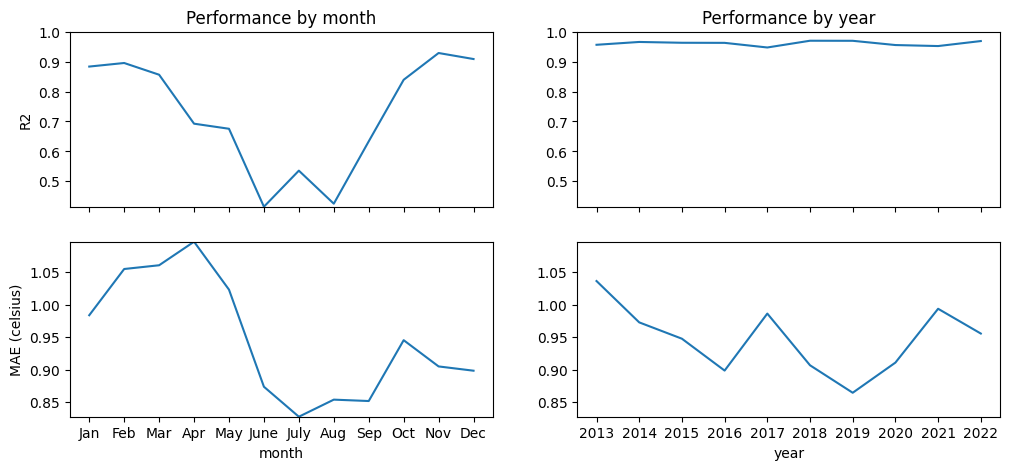

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 5))

# Monthly
df_scores_monthly["R2"].plot(ax=axs[0][0])
df_scores_monthly["MAE"].plot(ax=axs[1][0])
axs[0][0].set_xticklabels([])
axs[0][0].set_xlabel("")
axs[0][0].set_xticks(range(1, 13))
axs[1][0].set_xticks(range(1, 13))
axs[1][0].set_xticklabels(month_labels)
axs[0][0].set_ylabel("R2")
axs[1][0].set_ylabel("MAE (celsius)")
axs[0][0].set_title("Performance by month")

# Yearly
df_scores_yearly["R2"].plot(ax=axs[0][1])
df_scores_yearly["MAE"].plot(ax=axs[1][1])
axs[0][1].set_xticklabels([])
axs[0][1].set_xlabel("")
axs[0][1].set_xticks(years)
axs[0][1].set_xticklabels(["" for y in years])
axs[1][1].set_xticks(years)
axs[0][1].set_title("Performance by year")

miny = min(df_scores_monthly["R2"].min(), df_scores_yearly["R2"].min())
maxy = max(df_scores_monthly["R2"].max(), df_scores_yearly["R2"].max())
axs[0][0].set_ylim([miny, 1.0])
axs[0][1].set_ylim([miny, 1.0])

miny = min(df_scores_monthly["MAE"].min(), df_scores_yearly["MAE"].min())
maxy = max(df_scores_monthly["MAE"].max(), df_scores_yearly["MAE"].max())
axs[1][0].set_ylim([miny, maxy])
axs[1][1].set_ylim([miny, maxy])

The above reveals that errors are strongly influenced by the month.

According to the R2 results, the model struggles with hotter months (June - Sept): the R2 value drops considerably. This agrees with our idea that the model may struggle with hotter values due to the cold temperature skew.

However, those same months exhibit relatively lower MAE. This suggests that can generally capture relatively accurate values, but struggles to capture the shape. The model is not following the rise and fall in temperature as well as it does during the rest of the year.

This demonstrates how different metrics reveal different model characteristics. With a single metric, a model might appear to perform better than it really does.

**Caution:** analysis of the independent test set cause a sneaky issue to arise.

The idea of the **test set** is that we look at it *after* model development. **training** data is used to train the model (optimize model parameters) and **validation** data is used to refine the model architecture (optimize model hyperparameters).

But, what if our analysis of the test data gives us a new idea for model improvement? If we keep looking at the "independent" test set to refine our model... *it becomes validation data instead!*

# Data distribution performance

Models are not always uniformly skillful across the data distribution. So far, we have observed evidence that the model may struggle with hotter temperatures since (1) the observations have a colder skew, (2) reduced performance in summer.

So, we can analyze model performance within subsets of the data, grouping by ranges of temperature values. For example, computing MAE for average, colder, and hotter targets. For our modelling task (predicting cold stun events), we are particularly interested in performance around the cold stun threshold.

In [ ]:
# Data-driven approach: use histogram methods to bin the data
n_bins = 20

hist, bin_edges = np.histogram(dfy["target"], bins=n_bins)
bin_idxs = np.digitize(dfy["target"], bin_edges)
dfy["bin"] = bin_idxs

In [ ]:
# Calculate the scores within each bin
scores = np.zeros((n_bins, 4))

for bin_idx in range(n_bins):

  df_ = dfy[dfy["bin"] == bin_idx + 1]

  # CAUTION: R2 is not effective for highly restricted ranges of the target
  # With increasing number of bins, R2 tends to go extremely low (negative)... misleading
  #R2 = r2_score(df_["target"], df_["prediction"])

  MAE = mean_absolute_error(df_["target"], df_["prediction"])
  MSE = mean_squared_error(df_["target"], df_["prediction"])
  RMSE = root_mean_squared_error(df_["target"], df_["prediction"])

  scores[bin_idx] = [R2, MAE, MSE, RMSE]

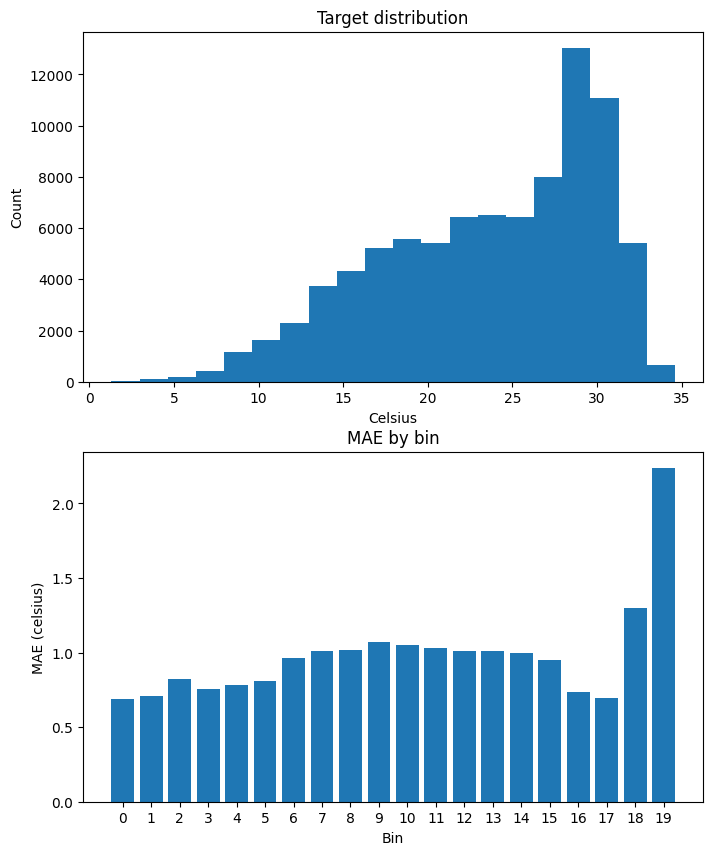

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10))

axs[0].hist(dfy["target"], bins=20)
axs[0].set_title("Target distribution")
axs[0].set_xlabel("Celsius")
axs[0].set_ylabel("Count")

axs[1].bar(range(n_bins), scores[:,1])
axs[1].set_title("MAE by bin")
axs[1].set_xlabel("Bin")
axs[1].set_ylabel("MAE (celsius)")

axs[1].set_xticks(range(n_bins));

As expected, the lowest MAE values are associated with the two bins with the largest number of cases. The model can more easily learn the average case with its large number of training samples.

Interestingly, we do not observe severe performance degredation for the colder cases. Instead, MAE rises sharply with hotter temperatures. Likely, this occurs because the temperature distribution is scaled cold and it is challenging to capture the hot temperature relationships using the available input variables (air and water temp).

# Task performance (cold stun events)

While it is important to analyze model skill across the data distribution, it is most important to ensure that the model performs well when it is critical for decision-making. In this case, our goal is to accurately forecast when the temperatures cross the threshold that triggers cold stunning in sea turtles.

In [ ]:
# Focus only on cold stun cases
cold_stun_threshold = 8.0 # Celsius

dfcs = dfy[dfy["target"] <= cold_stun_threshold]
ncs = len(dfcs)

print("Found {} cold stun events ({} / {} = {:.4f})".format(ncs, ncs, len(dfy), ncs/len(dfy)))

Found 794 cold stun events (794 / 87624 = 0.0091)


For all cold-stun cases, compare targets and predictions.

Text(0, 0.5, 'Celsius')

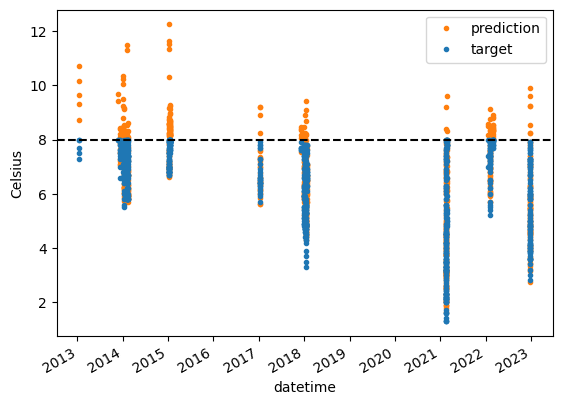

In [ ]:
dfcs["prediction"].plot(style=".", c=pcolor)
dfcs["target"].plot(style=".", c=tcolor)
plt.axhline(y=cold_stun_threshold, color='black', linestyle='--')
plt.legend()
plt.ylabel("Celsius")

Not all years have a cold stunning event, but we can see several cases where the predicted values are >2 degrees C above the cold stunning threshold. In practice, this can impact real-world operations.

(recall: our actual operational model is better than this toy example!)

**Global hits and misses**

In [ ]:
n_misses = len(dfcs[dfcs["prediction"] > cold_stun_threshold])
n_hits = len(dfcs[dfcs["prediction"] <= cold_stun_threshold])

print("Misses: {} ({:.4f})".format(n_misses, n_misses/ncs))
print("Hits: {} ({:.4f})".format(n_hits, n_hits/ncs))

Misses: 153 (0.1927)
Hits: 641 (0.8073)


**Yearly hits and misses**

In [ ]:
outcomes = np.zeros((len(years), 2))

for yidx, y in enumerate(years):
  df_ = dfcs[dfcs.index.year == y]
  n_misses = len(df_[df_["prediction"] > cold_stun_threshold])
  n_hits = len(df_[df_["prediction"] <= cold_stun_threshold])
  outcomes[yidx][0] = n_misses
  outcomes[yidx][1] = n_hits

outcomes_df = pd.DataFrame(outcomes, columns=["misses", "hits"], index=years)
outcomes_df.index.name = "year"

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

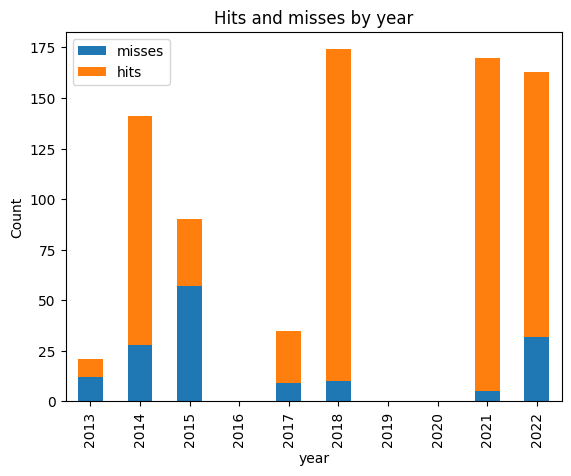

In [ ]:
outcomes_df.plot.bar(stacked=True)
plt.ylabel("Count")
plt.title("Hits and misses by year")
plt

While there are misses, the model does identify that vast majority of temperature below the threshold. This might suggest that the model could be useful, if imperfect, for the cold stun prediction task.

# Model skill

Performance metrics, alone, can be misleading.

If the trained model has really learned predictive strategies, then it should outperform simpler, naive baseline approaches.

A good way to measure model **skill** is by comparing the predictions to those from an appropriate baseline.

But, it may require some domain knowledge to select an appropriate baseline.

A trivial baseline would be to always predict the mean. But, this is probably *too* naive to be useful since it ignores seasonality and the diurnal cycle.

A common baseline for time series is the **persistence model** where the current value is used as the predicted value (no change).


In [ ]:
# Persistence model: use water temp at t-0 as prediction for t+12
dfy["persistence"] = x[:,-2]

**Global skill**

In [ ]:
R2_persistence = r2_score(dfy["target"], dfy["persistence"])
R2_prediction = r2_score(dfy["target"], dfy["prediction"])

skill = R2_prediction - R2_persistence

print("R2 persistence: {:.3f}".format(R2_persistence))
print("R2 prediction: {:.3f}".format(R2_prediction))
print("Skill (improvement in R2): {:.3f}".format(skill))
print("Proportion of R2 gap obtained with prediction: {:.3f}".format(skill / (1 - R2_persistence)))

R2 persistence: 0.835
R2 prediction: 0.962
Skill (improvement in R2): 0.127
Proportion of R2 gap obtained with prediction: 0.772


Based on the above, we can see that the MLP model does outperform the persistence baseline. However, the strong autocorrelation between water temperatures is such that the baseline does provide an R2 over 0.8.

**Cold stun event skill**

Finally, we should compare the model and baseline performance for our task: the cold stunning events.

In [ ]:
dfcs = dfy[dfy["target"] <= cold_stun_threshold]

outcomes_persistence = np.zeros((len(years), 2))

for yidx, y in enumerate(years):
  df_ = dfcs[dfcs.index.year == y]
  n_misses = len(df_[df_["persistence"] > cold_stun_threshold])
  n_hits = len(df_[df_["persistence"] <= cold_stun_threshold])
  outcomes_persistence[yidx][0] = n_misses
  outcomes_persistence[yidx][1] = n_hits

outcomes_df_persistence = pd.DataFrame(outcomes_persistence, columns=["misses", "hits"], index=years)
outcomes_df_persistence.index.name = "year"

Text(0.5, 1.0, 'Hits and misses by year (prediction model)')

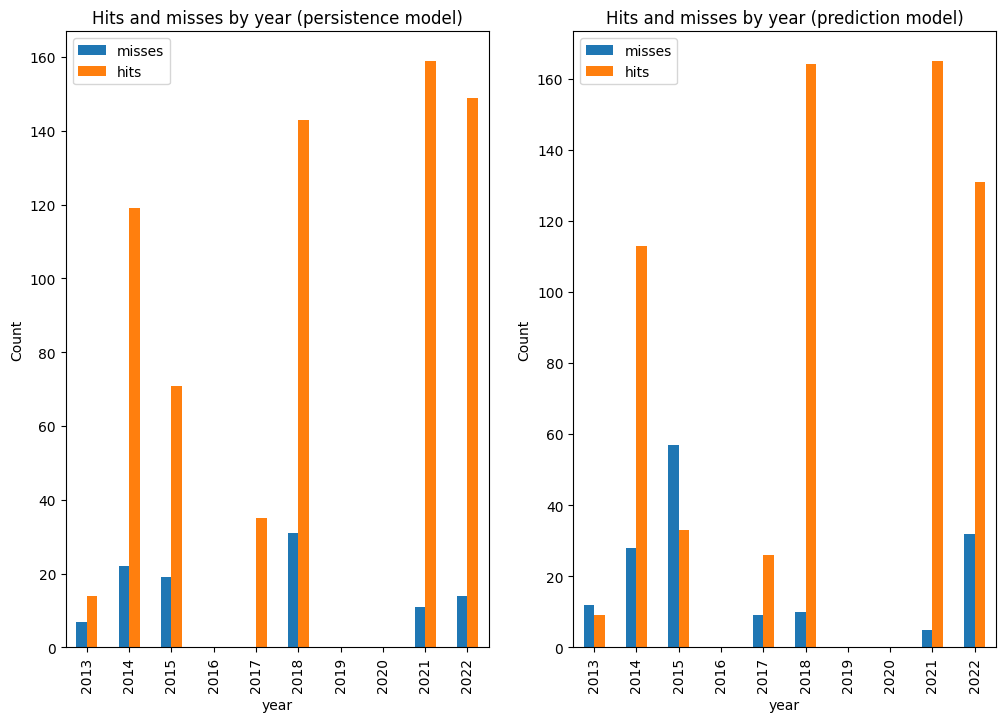

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

outcomes_df_persistence.plot.bar(ax=axs[0])
axs[0].set_ylabel("Count")
axs[0].set_title("Hits and misses by year (persistence model)")

outcomes_df.plot.bar(ax=axs[1])
axs[1].set_ylabel("Count")
axs[1].set_title("Hits and misses by year (prediction model)")

**Important!**

This comparison reveals that are model might not be as useful as we hoped.

Up until now, our progression through the performance evaluation steps hinted that our model has achieved some degree of performance that could be useful for our cold-stun forecast task:

1. Overall R2 is relatively high
2. Large underpredictions associated with hotter-than-average temperatures aren't relavant to our task
3. Model generalization appears to be okay, with 2022 performance comparable to other years

But, critically, **the MLP model does not outperform a simple persistence for the most critical task: predicting when the temperature crosses the cold stun threshold!**

This result highlights the importance of an in-depth model evaluation that focuses on how the model will impact decisions.